100%|██████████| 45/45 [00:00<00:00, 251.20it/s]


Node target asli: 0


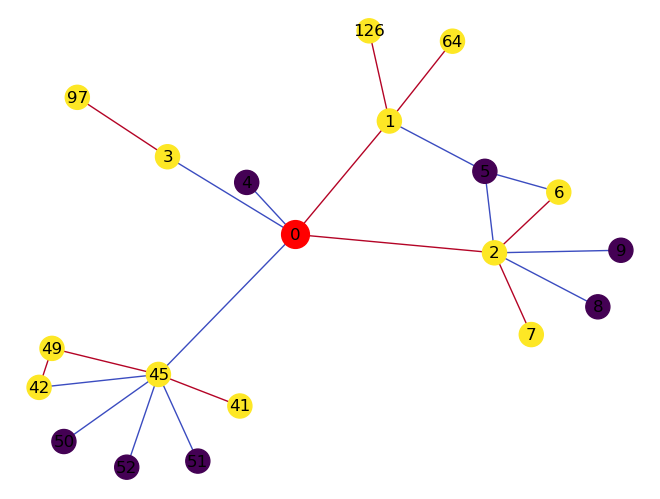

In [8]:
from graphxai.datasets import ShapeGGen
from graphxai.gnn_models.node_classification.testing import GCN_2layer
from graphxai.visualization.explanation_vis import visualize_node_explanation
from graphxai.explainers import GNNExplainer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1. Load synthetic dataset
dataset = ShapeGGen(num_graphs=1, task='node', make_explanations=False)
data = dataset.graph
data.train_mask = torch.ones(data.num_nodes, dtype=torch.bool)

# 2. Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_2layer(
    hidden_channels=16,
    input_feat=data.x.shape[1],
    classes=int(data.y.max().item()) + 1
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3. Train model pada data yang sama
data = data.to(device)
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# 4. Pilih node target dengan label 1 (fraud)
target_node = (data.y == 1).nonzero(as_tuple=True)[0][0].item()

# 5. Explain dengan GNNExplainer
model.eval()
explainer = GNNExplainer(model)
exp = explainer.get_explanation_node(
    node_idx=target_node,
    x=data.x,
    edge_index=data.edge_index,
    label=data.y
)
print("Node target asli:", exp.node_idx)
# 6. Visualisasi hasil explainability
# visualize_node_explanation(exp, show=True, connected=False)
exp.visualize_node(
    num_hops=1,                 # jumlah hops asli dari explainer
    graph_data=data,            # graf lengkap untuk konteks
    additional_hops=1,          # tampilkan 1-hop ekstra dari sekeliling subgraf
    heat_by_exp=True,           # aktifkan pewarnaan berdasarkan importance
    heat_by_prescence=False,    # tidak hanya menyorot kehadiran saja
    show=True,                  # langsung tampilkan visualisasi
    show_node_labels=True       # tampilkan label angka node
)

In [10]:
print(f"Label node 1:", data.y[1].item())
print(f"Label node 6:", data.y[6].item())
print(f"Label node 3:", data.y[3].item())
print(f"Label node 7:", data.y[7].item())

Label node 1: 1
Label node 6: 1
Label node 3: 1
Label node 7: 1


In [11]:
def print_explainer_node_mapping(exp, topk=5):
    """
    Menampilkan mapping dari ID visual ➝ ID asli, dan node paling penting.
    """

    G, node_map = exp.enc_subgraph_to_networkx(get_map=True)
    # node_map: real_id → visual_id
    # Kita ingin visual_id → real_id
    inv_node_map = {v: k for k, v in node_map.items()}

    print("\n📍 Mapping Node Visual ➝ Node Asli:")
    for v_id, r_id in inv_node_map.items():
        print(f"Node visual {v_id} → Node asli {r_id}")

    print("\n⭐ Node dengan Kontribusi Terbesar:")
    node_importances = []
    for v_id in G.nodes:
        real_id = inv_node_map[v_id]
        imp = exp.node_imp[exp.node_reference[real_id]]
        node_importances.append((real_id, float(imp)))

    sorted_nodes = sorted(node_importances, key=lambda x: x[1], reverse=True)
    for i, (n_id, score) in enumerate(sorted_nodes[:topk]):
        print(f"{i+1}. Node {n_id} (importance = {score:.3f})")

    print("\n🔗 Edge yang Termasuk Subgraf (ID Asli):")
    for u_viz, v_viz in G.edges():
        u_real, v_real = inv_node_map[u_viz], inv_node_map[v_viz]
        print(f"Edge visual ({u_viz}, {v_viz}) → Edge asli ({u_real}, {v_real})")
print_explainer_node_mapping(exp)


📍 Mapping Node Visual ➝ Node Asli:
Node visual 0 → Node asli 0
Node visual 1 → Node asli 1
Node visual 2 → Node asli 2
Node visual 3 → Node asli 3
Node visual 4 → Node asli 4
Node visual 5 → Node asli 5
Node visual 6 → Node asli 6
Node visual 7 → Node asli 7
Node visual 8 → Node asli 8
Node visual 9 → Node asli 9
Node visual 10 → Node asli 41
Node visual 11 → Node asli 42
Node visual 12 → Node asli 45
Node visual 13 → Node asli 49
Node visual 14 → Node asli 50
Node visual 15 → Node asli 51
Node visual 16 → Node asli 52
Node visual 17 → Node asli 64
Node visual 18 → Node asli 97
Node visual 19 → Node asli 126

⭐ Node dengan Kontribusi Terbesar:
1. Node 0 (importance = 1.000)
2. Node 1 (importance = 1.000)
3. Node 2 (importance = 1.000)
4. Node 3 (importance = 1.000)
5. Node 6 (importance = 1.000)

🔗 Edge yang Termasuk Subgraf (ID Asli):
Edge visual (0, 1) → Edge asli (0, 1)
Edge visual (0, 2) → Edge asli (0, 2)
Edge visual (0, 3) → Edge asli (0, 3)
Edge visual (0, 4) → Edge asli (0, 4)